Innanzitutto uso una GPU per velocizzare il training

In [ ]:
import tensorflow as tf

# usa GPU
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

No GPU, using /device:CPU:0.


Download del dataset

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteEVOYY8/eurosat-train.tfrecord*...:   0%|      …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


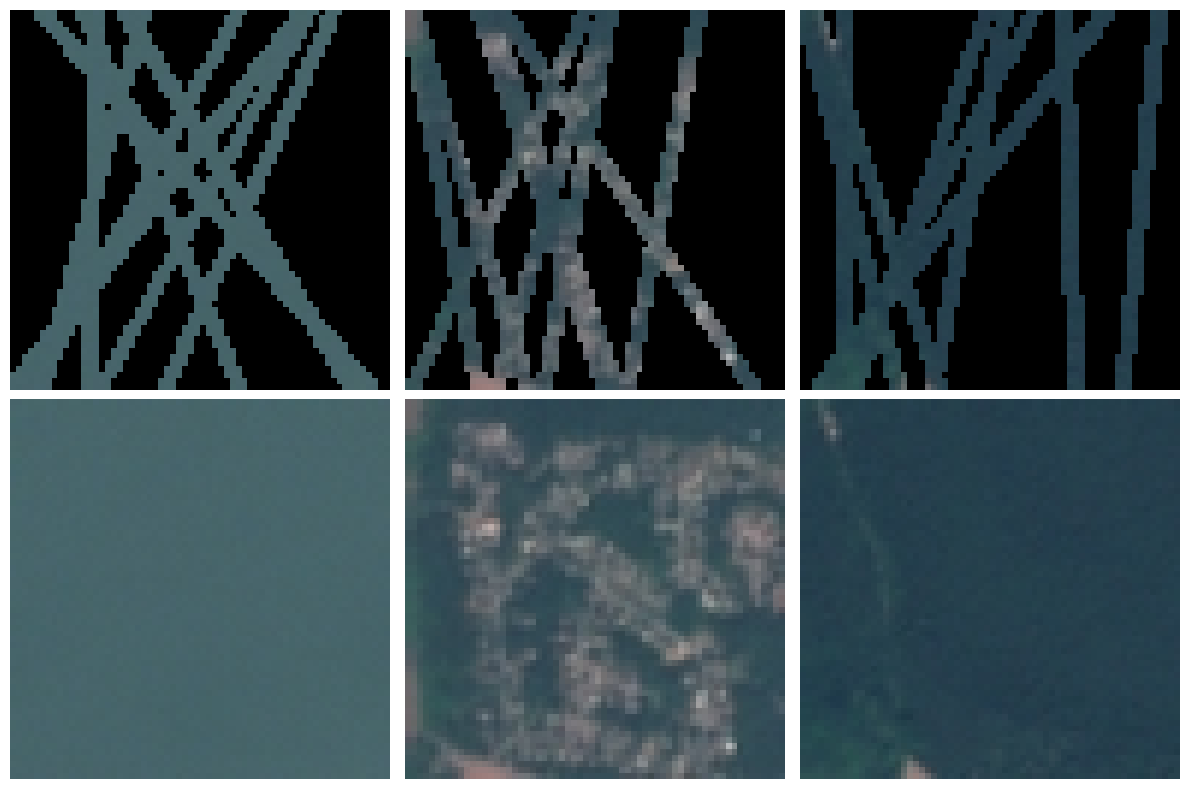

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import cv2

ds_train, ds_info = tfds.load(
    'eurosat/rgb',
    shuffle_files=False,
    #as_supervised=True,  # Returns a tuple (img, label) instead of a dictionary {'image': img, 'label': label}
    with_info=True
)

ds_train = ds_train['train']
ds_train = ds_train.shuffle(1000, seed = 42)
train_dataset = ds_train.take(20000)
test_dataset = ds_train.skip(20000)

def generator(dataset,nolines=9):
    while True:  # Start an infinite loop
        for batch in dataset:
            images = batch["image"]
            images_np = images.numpy()

            masks = np.zeros((batch_size, 64, 64))
            for i in range(batch_size):
                for j in range(nolines):
                    start_point = (np.random.randint(0, 64 - 1), 0)
                    end_point = (np.random.randint(0, 64 - 1), 63)
                    thickness = np.random.randint(2, 3)
                    masks[i] = cv2.line(masks[i], start_point, end_point, (1), thickness)

            images_np = images_np / 255.0
            masks = np.stack(((masks),) * 3, axis=-1)

            yield (images_np * masks, images_np)

# Batch the datasets
batch_size = 8
train_dataset_batched = train_dataset.batch(batch_size)
test_dataset_batched = test_dataset.batch(batch_size)

# Create generators for the batched datasets
train_generator = generator(train_dataset_batched)
test_generator = generator(test_dataset_batched)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))  # Adjust figsize as needed
a,b = next(train_generator)
for i in range(3):
  # Plot image on each subplot
  axes[0,i].imshow(a[i])  # Use cmap='gray' if your images are grayscale
  axes[0,i].axis('off')  # Turn off axis
  axes[1,i].imshow(b[i])  # Use cmap='gray' if your images are grayscale
  axes[1,i].axis('off')  # Turn off axis

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Il modello usato è una U-Net, con strati di convoluzione per codifica (che cattura le caratteristiche principali dell'immagine) e decodifica (che ricostruisce l'immagine con le informazioni del percorso di codifica), con skip connections per mantenere dettagli di basso livello.
Qui vengono usate 20 epoche, più epoche credo causerebbero overfitting visto che il miglioramento non è veloce.
Ho usato tanti steps per epoca in modo che il modello veda il più immagini possibili per generalizzare la soluzione.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

LOAD_WEIGHTS = False

# se ho già i pesi 0 epochs, altrimenti alleno per x epochs
if(LOAD_WEIGHTS==False):
  EPOCHS = 20
else:
  EPOCHS = 0


# Define U-Net model
def unet_model(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    # Downsampling path
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Upsampling path
    up5 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = tf.keras.layers.concatenate([up5, conv3], axis=3)
    conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = tf.keras.layers.concatenate([up6, conv2], axis=3)
    conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = tf.keras.layers.concatenate([up7, conv1], axis=3)
    conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = tf.keras.layers.Conv2D(3, 1, activation='sigmoid')(conv7)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (64, 64, 3)
model = unet_model(input_shape)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Lower learning rate

model.compile(optimizer=optimizer, loss='mse')

# model.load_weights('/content/drive/MyDrive/Python/unetv2_weights.h5')


# Train the model
history = model.fit(train_generator, epochs=EPOCHS, steps_per_epoch=20000 // batch_size, validation_data=test_generator, validation_steps=5000//batch_size)


Epoch 1/20
2500/2500 [==============================] - 100s 35ms/step - loss: 0.0044 - val_loss: 0.0033
Epoch 2/20
2500/2500 [==============================] - 137s 55ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 3/20
2500/2500 [==============================] - 85s 34ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 4/20
2500/2500 [==============================] - 142s 57ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 5/20
2500/2500 [==============================] - 83s 33ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 6/20
2500/2500 [==============================] - 159s 64ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 7/20
2500/2500 [==============================] - 83s 33ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 8/20
2500/2500 [==============================] - 83s 33ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 9/20
2500/2500 [==============================] - 123s 49ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 10/20
2500/2500 [==============================] - 15

In [ ]:
model.save_weights('/content/drive/MyDrive/Python/unetv2_weights.h5')

Qui valutiamo la qualità della ricostruzione, calcolando il Mean Squared Error (MSE) tra immagini originali e le immagini ricostruite (10000 immagini).
Il calcolo viene fatto per 10 volte e poi viene calcolata la media.

In [ ]:
def calculate_mse(model, test_generator, num_images):
    total_mse = 0.0
    for _ in range(num_images):
        test_images, true_images = next(test_generator)
        reconstructed_images = model.predict(test_images)

        mse = np.mean(np.square(true_images - reconstructed_images))

        total_mse += mse

    mean_mse = total_mse / num_images
    mse_values = [(mse - mean_mse) ** 2 for _ in range(num_images)]
    std_dev = np.sqrt(np.mean(mse_values))

    return mean_mse, std_dev

# Define parameters
num_images = 10000
num_runs = 10

mse_values = []

for _ in range(num_runs):
    mean_mse, std_dev = calculate_mse(model, test_generator, num_images)

    mse_values.append(mean_mse)

mean_mse_overall = np.mean(mse_values)
std_dev_overall = np.std(mse_values)

# Print results
print("Mean MSE over 10 runs:", mean_mse_overall)
print("Standard deviation of MSE over 10 runs:", std_dev_overall)


Output streaming troncato alle ultime 5000 righe.
1/1 [==============================] - 0s 456ms/step
Mean MSE over 10 runs: 0.0024450235094476773
Standard deviation of MSE over 10 runs: 0.0


Non capisco perchè la standard deviation sia zero, ma non ho modo di rilanciare il programma perchè Colab mi blocca la sua GPU, e usando la mia CPU ci metterei circa 13-14 ore.